In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [430]:
train['Income'].value_counts()[:50].values

array([8697,  743,  550,  547,  526,  401,  389,  342,  281,  245,  239,
        226,  208,  206,  202,  200,  163,  153,  147,  147,  143,  111,
        110,  107,  105,  103,   95,   85,   77,   75,   66,   61,   54,
         53,   53,   49,   47,   45,   42,   40,   37,   36,   30,   28,
         27,   27,   27,   26,   24,   24], dtype=int64)

<Axes: ylabel='Frequency'>

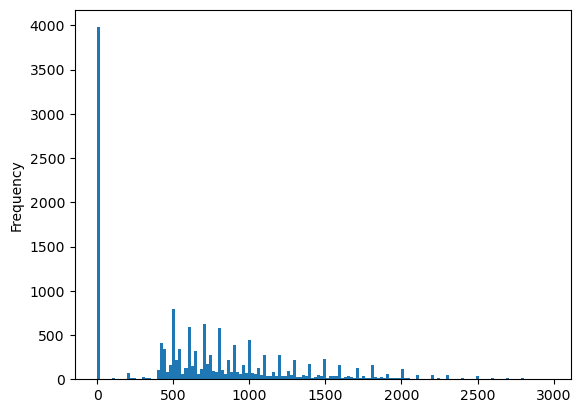

In [237]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
train = train[train['Age'] > 14]
train = train[train['Employment_Status'] != 'Not Working']
train = train[train['Industry_Status'] != 'Not in universe or children']
train[train['Income'] < 3000]['Income'].plot.hist(bins=150)

In [266]:
train

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Race,Hispanic_Origin,Martial_Status,...,Citizenship,Birth_Country,Birth_Country (Father),Birth_Country (Mother),Tax_Status,Gains,Losses,Dividends,Income_Status,Income
0,63,M,Middle (7-8),Full-Time,4,Social Services,Services,White,All other,Married,...,Native,US,US,US,Nonfiler,0,0,0,Unknown,425
1,37,M,Associates degree (Vocational),Full-Time,52,Entertainment,Services,White,All other,Separated,...,Native,US,US,US,Single,0,0,0,Under Median,0
2,58,F,High graduate,Full-Time,52,Manufacturing (Non-durable),Admin Support (include Clerical),Black,All other,Married,...,Native,US,US,US,Married Filling Jointly both under 65 (MFJ),3411,0,0,Under Median,860
3,44,M,High graduate,Full-Time,52,Retail,Technicians & Support,White,All other,Divorced,...,Native,US,US,US,Single,0,0,0,Under Median,850
4,37,F,High graduate,Full-Time,52,Retail,Sales,White,All other,Divorced,...,Native,US,US,US,Head of Household (HOH),0,0,0,Unknown,570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,41,M,High graduate,Full-Time,52,Retail,Sales,White,All other,Separated,...,Native,US,US,US,Single,0,0,0,Under Median,900
19995,33,M,High graduate,Children or Armed Forces,52,Manufacturing (Durable),Handlers/Cleaners,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Under Median,1300
19996,20,F,College,Full-Time,12,Education,Admin Support (include Clerical),White,Mexican-American,Single,...,Native,US,Mexico,Mexico,Nonfiler,0,0,0,Under Median,850
19997,22,M,College,Children or Armed Forces,52,Transportation,Technicians & Support,White,All other,Single,...,Native,US,US,US,Single,0,0,0,Unknown,999


Children or Armed Forces         477
Full-Time                        342
Choice Part-Time                  29
Part-Time (Usually Part-Time)      5
Part-Time (Usually Full-Time)      3
Seeking Full-Time                  3
Seeking Part-Time                  3
Not Working                        0
Name: Employment_Status, dtype: int64

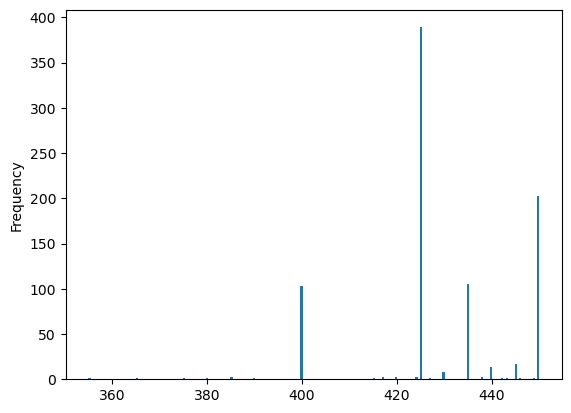

In [29]:
s = 350
e = s + 100
train[(train['Income'] > s) & (train['Income'] <= e)]['Income'].plot.hist(bins=200)
train[(train['Income'] > s) & (train['Income'] <= e)]['Employment_Status'].value_counts()

In [33]:
train[train['Income'] == 425]

,Age,Gender,Education_Status,Employment_Status,Working_Week (Yearly),Industry_Status,Occupation_Status,Hispanic_Origin,Martial_Status,Household_Status,...,Industry_Status_encoded,Occupation_Status_encoded,Hispanic_Origin_encoded,Martial_Status_encoded,Household_Status_encoded,Birth_Country_encoded,Birth_Country (Father)_encoded,Birth_Country (Mother)_encoded,Tax_Status_encoded,Income_Status_encoded
0,63,M,Middle (7-8),Full-Time,4,Social Services,Services,All other,Married,Householder,...,608.765668,512.062257,574.993697,687.201172,728.328241,560.650659,574.009177,571.103049,60.947341,545.810820
63,27,F,High graduate,Children or Armed Forces,52,Retail,Sales,All other,Married,Spouse of householder,...,527.744681,488.010638,574.993697,687.201172,620.124322,560.650659,574.009177,571.103049,742.472403,545.810820
173,67,F,High graduate,Full-Time,52,Retail,Sales,All other,Married,Spouse of householder,...,527.744681,488.010638,574.993697,687.201172,620.124322,560.650659,574.009177,571.103049,203.144989,537.030294
212,17,M,High Senior,Full-Time,0,Personal Services (except Private Household),Services,All other,Single,Child <18 never marr not in subfamily,...,473.620047,512.062257,574.993697,368.479404,63.779775,560.650659,574.009177,571.103049,60.947341,537.030294
296,20,M,High Sophomore,Choice Part-Time,12,Retail,Sales,Mexican-American,Single,Child 18+ never marr Not in a subfamily,...,527.744681,488.010638,420.946483,368.479404,505.561828,560.650659,574.009177,571.103049,60.947341,537.030294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19742,59,F,Elementary (5-6),Full-Time,5,Personal Services (except Private Household),Services,Mexican-American,Married,Spouse of householder,...,473.620047,512.062257,420.946483,687.201172,620.124322,560.650659,574.009177,571.103049,60.947341,537.030294
19796,25,M,College,Children or Armed Forces,40,Retail,Sales,All other,Single,Child 18+ never marr Not in a subfamily,...,527.744681,488.010638,574.993697,368.479404,505.561828,560.650659,574.009177,571.103049,615.808365,537.030294
19906,21,F,College,Full-Time,20,Retail,Services,Mexican-American,Married,Householder,...,527.744681,512.062257,420.946483,687.201172,728.328241,560.650659,381.119527,571.103049,742.472403,545.810820
19931,19,F,College,Children or Armed Forces,28,Retail,Services,All other,Single,Other Rel 18+ never marr not in subfamily,...,527.744681,512.062257,574.993697,368.479404,398.989744,560.650659,574.009177,571.103049,615.808365,545.810820


In [284]:
s = 2000
e = s + 100
train[(train['Income'] > s) & (train['Income'] <= e)].loc[:,['Age','Income']].mean()

Age         38.263158
Income    2076.578947
dtype: float64

In [6]:
# train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
# test = pd.read_csv('./open/test.csv').drop('ID',axis=1)

# for column in tqdm(train.columns):
#     if train[column].dtype == 'object' and train[column].nunique() <= 4:  # 가짓수가 4 이상인 경우
#         encoded = pd.get_dummies(train[column], prefix=column)
#         train = pd.concat([train.drop(column, axis=1), encoded], axis=1)

# train

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 162.50it/s]


,Age,Gender,Working_Week (Yearly),Gains,Losses,Dividends,Income_Status,Income,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),...,Birth_Country (Mother)_US,Birth_Country (Mother)_Unknown,Birth_Country (Mother)_Vietnam,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single
0,63,M,4,0,0,0,Unknown,425,0,0,...,1,0,0,0,0,0,0,0,1,0
1,37,M,52,0,0,0,Under Median,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,58,F,52,3411,0,0,Under Median,860,0,0,...,1,0,0,0,0,0,1,0,0,0
3,44,M,52,0,0,0,Under Median,850,0,0,...,1,0,0,0,0,0,0,0,0,1
4,37,F,52,0,0,0,Unknown,570,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,M,52,0,0,0,Under Median,1300,0,0,...,1,0,0,0,0,0,0,0,0,1
19996,20,F,12,0,0,0,Under Median,850,0,0,...,0,0,0,0,0,0,0,0,1,0
19997,22,M,52,0,0,0,Unknown,999,0,0,...,1,0,0,0,0,0,0,0,0,1
19998,76,F,0,0,0,0,Under Median,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [382]:
from pycaret.regression import *

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# object_columns = train.select_dtypes(include=['object']).columns
# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Income'] > 0)]
data = data.drop('ID',axis=1)
# PyCaret 회귀 모델 설정
regression_setup = setup(data, target='Income',
                         max_encoding_ohe=2,
                         train_size=0.8,
                         fold=10,
                         session_id=42)

# 다양한 회귀 모델 비교
best_model = compare_models(n_select=3, sort='RMSE')

,Description,Value
0,Session id,42
1,Target,Income
2,Target type,Regression
3,Original data shape,"(11145, 22)"
4,Transformed data shape,"(11145, 22)"
5,Transformed train set shape,"(8916, 22)"
6,Transformed test set shape,"(2229, 22)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,245.3501,116540.8445,341.1393,0.4830,0.3453,0.3015,0.1380
gbr,Gradient Boosting Regressor,247.8585,116648.9367,341.2743,0.4825,0.3484,0.3070,0.3120
catboost,CatBoost Regressor,246.1275,117163.0712,342.0395,0.4803,0.3463,0.3018,1.1970
rf,Random Forest Regressor,255.7584,124433.9414,352.4927,0.4478,0.3581,0.3171,0.7710
xgboost,Extreme Gradient Boosting,254.6904,124953.4822,353.2407,0.4457,0.3581,0.3118,0.3330
lr,Linear Regression,269.2051,128653.5888,358.3658,0.4295,0.3818,0.3395,0.6470
ridge,Ridge Regression,269.2051,128653.6226,358.3658,0.4295,0.3818,0.3395,0.1050
lasso,Lasso Regression,269.2111,128660.6103,358.3749,0.4295,0.3816,0.3395,0.1070
llar,Lasso Least Angle Regression,269.2111,128660.6274,358.3749,0.4295,0.3816,0.3395,0.0990
lar,Least Angle Regression,269.2638,128685.2041,358.4103,0.4294,0.3820,0.3396,0.1000


In [127]:
train.columns

Index(['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [ ]:
# feaature engineering

In [27]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    return train, test

train, test = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    # 교차 검증 설정 (5-Fold 교차 검증 사용)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]

        # LightGBM 모델 정의
        model = lgb.LGBMRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-04-06 19:13:35,586] A new study created in memory with name: no-name-a86a5d1b-73c1-439b-bb91-71f48616c0eb
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/rele

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6765105587216462, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765105587216462
[LightGBM] [Warning] bagging_fraction is set=0.5003503948204289, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5003503948204289
[LightGBM] [Warning] lambda_l1 is set=0.12716582248617586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12716582248617586
[LightGBM] [Warning] lambda_l2 is set=5.549237613796526e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.549237613796526e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:13:38,217] Trial 0 finished with value: 581.3402977954041 and parameters: {'lambda_l1': 0.12716582248617586, 'lambda_l2': 5.549237613796526e-07, 'num_leaves': 57, 'learning_rate': 0.00034589811443077353, 'feature_fraction': 0.6765105587216462, 'bagging_fraction': 0.5003503948204289, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8316918485481672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8316918485481672
[LightGBM] [Warning] bagging_fraction is set=0.9867985051786643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867985051786643
[LightGBM] [Warning] lambda_l1 is set=0.01892199137437504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01892199137437504
[LightGBM] [Warning] lambda_l2 is set=2.8010397688303588, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8010397688303588
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-04-06 19:13:42,995] Trial 1 finished with value: 588.5248688977109 and parameters: {'lambda_l1': 0.01892199137437504, 'lambda_l2': 2.8010397688303588, 'num_leaves': 142, 'learning_rate': 1.5328555326522944e-06, 'feature_fraction': 0.8316918485481672, 'bagging_fraction': 0.9867985051786643, 'bagging_freq': 7, 'min_child_samples': 41}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7134110906209816, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7134110906209816
[LightGBM] [Warning] bagging_fraction is set=0.8747631793385902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8747631793385902
[LightGBM] [Warning] lambda_l1 is set=0.00472498693495823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00472498693495823
[LightGBM] [Warning] lambda_l2 is set=2.01019012490515e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.01019012490515e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:13:47,262] Trial 2 finished with value: 588.5548192110737 and parameters: {'lambda_l1': 0.00472498693495823, 'lambda_l2': 2.01019012490515e-06, 'num_leaves': 202, 'learning_rate': 1.7442607040036414e-07, 'feature_fraction': 0.7134110906209816, 'bagging_fraction': 0.8747631793385902, 'bagging_freq': 4, 'min_child_samples': 72}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8614302731625794, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8614302731625794
[LightGBM] [Warning] bagging_fraction is set=0.42808792887859287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42808792887859287
[LightGBM] [Warning] lambda_l1 is set=0.016428712372757833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.016428712372757833
[LightGBM] [Warning] lambda_l2 is set=0.046947455719050346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046947455719050346
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-04-06 19:13:51,565] Trial 3 finished with value: 588.5579000236824 and parameters: {'lambda_l1': 0.016428712372757833, 'lambda_l2': 0.046947455719050346, 'num_leaves': 212, 'learning_rate': 3.381489685517667e-08, 'feature_fraction': 0.8614302731625794, 'bagging_fraction': 0.42808792887859287, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6175072252288919, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6175072252288919
[LightGBM] [Warning] bagging_fraction is set=0.9687261184492634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9687261184492634
[LightGBM] [Warning] lambda_l1 is set=0.006558852021679427, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006558852021679427
[LightGBM] [Warning] lambda_l2 is set=3.7387054218284736e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7387054218284736e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:13:55,777] Trial 4 finished with value: 588.5579225507942 and parameters: {'lambda_l1': 0.006558852021679427, 'lambda_l2': 3.7387054218284736e-06, 'num_leaves': 155, 'learning_rate': 3.3331156032209684e-08, 'feature_fraction': 0.6175072252288919, 'bagging_fraction': 0.9687261184492634, 'bagging_freq': 4, 'min_child_samples': 87}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8658701142530205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8658701142530205
[LightGBM] [Warning] bagging_fraction is set=0.4844963355083458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4844963355083458
[LightGBM] [Warning] lambda_l1 is set=1.6756276496505504e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6756276496505504e-08
[LightGBM] [Warning] lambda_l2 is set=0.00040678717037641695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040678717037641695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-04-06 19:13:58,277] Trial 5 finished with value: 588.5544629850444 and parameters: {'lambda_l1': 1.6756276496505504e-08, 'lambda_l2': 0.00040678717037641695, 'num_leaves': 120, 'learning_rate': 1.9402166171336382e-07, 'feature_fraction': 0.8658701142530205, 'bagging_fraction': 0.4844963355083458, 'bagging_freq': 3, 'min_child_samples': 94}. Best is trial 0 with value: 581.3402977954041.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.485766123742613, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.485766123742613
[LightGBM] [Warning] bagging_fraction is set=0.7173421497640533, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7173421497640533
[LightGBM] [Warning] lambda_l1 is set=7.026922769951912e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.026922769951912e-08
[LightGBM] [Warning] lambda_l2 is set=7.853274000213279e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.853274000213279e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:14:02,255] Trial 6 finished with value: 559.6466344702113 and parameters: {'lambda_l1': 7.026922769951912e-08, 'lambda_l2': 7.853274000213279e-05, 'num_leaves': 71, 'learning_rate': 0.0015191722105518538, 'feature_fraction': 0.485766123742613, 'bagging_fraction': 0.7173421497640533, 'bagging_freq': 4, 'min_child_samples': 32}. Best is trial 6 with value: 559.6466344702113.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.880317463779122, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.880317463779122
[LightGBM] [Warning] bagging_fraction is set=0.44123564339103627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44123564339103627
[LightGBM] [Warning] lambda_l1 is set=2.0697857331554092e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0697857331554092e-08
[LightGBM] [Warning] lambda_l2 is set=5.343333307225277e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.343333307225277e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-04-06 19:14:06,288] Trial 7 finished with value: 588.5570710973582 and parameters: {'lambda_l1': 2.0697857331554092e-08, 'lambda_l2': 5.343333307225277e-05, 'num_leaves': 114, 'learning_rate': 7.12502589345164e-08, 'feature_fraction': 0.880317463779122, 'bagging_fraction': 0.44123564339103627, 'bagging_freq': 1, 'min_child_samples': 30}. Best is trial 6 with value: 559.6466344702113.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7571339808395308, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7571339808395308
[LightGBM] [Warning] bagging_fraction is set=0.5606046001342084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5606046001342084
[LightGBM] [Warning] lambda_l1 is set=0.003643399998710374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003643399998710374
[LightGBM] [Warning] lambda_l2 is set=0.35099147741865444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.35099147741865444
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-04-06 19:14:10,008] Trial 8 finished with value: 469.77029390147044 and parameters: {'lambda_l1': 0.003643399998710374, 'lambda_l2': 0.35099147741865444, 'num_leaves': 224, 'learning_rate': 0.013447064132746111, 'feature_fraction': 0.7571339808395308, 'bagging_fraction': 0.5606046001342084, 'bagging_freq': 1, 'min_child_samples': 42}. Best is trial 8 with value: 469.77029390147044.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.421565604721954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.421565604721954
[LightGBM] [Warning] bagging_fraction is set=0.43940797148191946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43940797148191946
[LightGBM] [Warning] lambda_l1 is set=0.15837387652587553, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.15837387652587553
[LightGBM] [Warning] lambda_l2 is set=7.054839292774888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.054839292774888
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:14:12,577] Trial 9 finished with value: 580.9862306295485 and parameters: {'lambda_l1': 0.15837387652587553, 'lambda_l2': 7.054839292774888, 'num_leaves': 178, 'learning_rate': 0.00039174061416754496, 'feature_fraction': 0.421565604721954, 'bagging_fraction': 0.43940797148191946, 'bagging_freq': 4, 'min_child_samples': 54}. Best is trial 8 with value: 469.77029390147044.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9835289789782334, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9835289789782334
[LightGBM] [Warning] bagging_fraction is set=0.6368703823968468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368703823968468
[LightGBM] [Warning] lambda_l1 is set=1.3232238606003047e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3232238606003047e-05
[LightGBM] [Warning] lambda_l2 is set=0.025892659651021627, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025892659651021627
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-04-06 19:14:18,999] Trial 10 finished with value: 481.64754543958196 and parameters: {'lambda_l1': 1.3232238606003047e-05, 'lambda_l2': 0.025892659651021627, 'num_leaves': 250, 'learning_rate': 0.509268049599265, 'feature_fraction': 0.9835289789782334, 'bagging_fraction': 0.6368703823968468, 'bagging_freq': 1, 'min_child_samples': 6}. Best is trial 8 with value: 469.77029390147044.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9503340914763618, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9503340914763618
[LightGBM] [Warning] bagging_fraction is set=0.6228686767759724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6228686767759724
[LightGBM] [Warning] lambda_l1 is set=1.574427353820858e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.574427353820858e-05
[LightGBM] [Warning] lambda_l2 is set=0.02994360612184703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02994360612184703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-04-06 19:14:25,113] Trial 11 finished with value: 489.0016250082461 and parameters: {'lambda_l1': 1.574427353820858e-05, 'lambda_l2': 0.02994360612184703, 'num_leaves': 245, 'learning_rate': 0.6251002206664477, 'feature_fraction': 0.9503340914763618, 'bagging_fraction': 0.6228686767759724, 'bagging_freq': 1, 'min_child_samples': 5}. Best is trial 8 with value: 469.77029390147044.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7507425227593848, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7507425227593848
[LightGBM] [Warning] bagging_fraction is set=0.6358836723005875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6358836723005875
[LightGBM] [Warning] lambda_l1 is set=2.7472586090824175e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7472586090824175e-05
[LightGBM] [Warning] lambda_l2 is set=0.018989608920789106, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018989608920789106
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-04-06 19:14:30,910] Trial 12 finished with value: 476.66521091367514 and parameters: {'lambda_l1': 2.7472586090824175e-05, 'lambda_l2': 0.018989608920789106, 'num_leaves': 242, 'learning_rate': 0.4192022301244531, 'feature_fraction': 0.7507425227593848, 'bagging_fraction': 0.6358836723005875, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 8 with value: 469.77029390147044.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7619836569724204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7619836569724204
[LightGBM] [Warning] bagging_fraction is set=0.7738809539633028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7738809539633028
[LightGBM] [Warning] lambda_l1 is set=0.0001643768704518228, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001643768704518228
[LightGBM] [Warning] lambda_l2 is set=1.9979391075167307e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9979391075167307e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-04-06 19:14:36,064] Trial 13 finished with value: 461.9515454488642 and parameters: {'lambda_l1': 0.0001643768704518228, 'lambda_l2': 1.9979391075167307e-08, 'num_leaves': 217, 'learning_rate': 0.017923037475602064, 'feature_fraction': 0.7619836569724204, 'bagging_fraction': 0.7738809539633028, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 13 with value: 461.9515454488642.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM] [Warning] lambda_l1 is set=0.0003471254794668613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003471254794668613
[LightGBM] [Warning] lambda_l2 is set=1.4635525888091753e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4635525888091753e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM] [Warning] lambda_l1 is set=0.0003471254794668613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003471254794668613
[LightGBM] [Warning] lambda_l2 is set=1.4635525888091753e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4635525888091753e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM] [Warning] lambda_l1 is set=0.0003471254794668613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003471254794668613
[LightGBM] [Warning] lambda_l2 is set=1.4635525888091753e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4635525888091753e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM] [Warning] lambda_l1 is set=0.0003471254794668613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003471254794668613
[LightGBM] [Warning] lambda_l2 is set=1.4635525888091753e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4635525888091753e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM] [Warning] lambda_l1 is set=0.0003471254794668613, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003471254794668613
[LightGBM] [Warning] lambda_l2 is set=1.4635525888091753e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4635525888091753e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5681209078700612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5681209078700612
[LightGBM] [Warning] bagging_fraction is set=0.7961368097453937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7961368097453937
[LightGBM

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
[I 2024-04-06 19:14:37,854] Trial 14 finished with value: 474.38569282158585 and parameters: {'lambda_l1': 0.0003471254794668613, 'lambda_l2': 1.4635525888091753e-08, 'num_leaves': 11, 'learning_rate': 0.014560150763746582, 'feature_fraction': 0.5681209078700612, 'bagging_fraction': 0.7961368097453937, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 13 with value: 461.9515454488642.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: 

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7771810068709293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7771810068709293
[LightGBM] [Warning] bagging_fraction is set=0.5595915102424222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5595915102424222
[LightGBM] [Warning] lambda_l1 is set=8.810121099092068, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.810121099092068
[LightGBM] [Warning] lambda_l2 is set=1.4276716066885781e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4276716066885781e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:14:41,305] Trial 15 finished with value: 462.4370456363117 and parameters: {'lambda_l1': 8.810121099092068, 'lambda_l2': 1.4276716066885781e-08, 'num_leaves': 197, 'learning_rate': 0.01863919394595631, 'feature_fraction': 0.7771810068709293, 'bagging_fraction': 0.5595915102424222, 'bagging_freq': 6, 'min_child_samples': 68}. Best is trial 13 with value: 461.9515454488642.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7925348814540354, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7925348814540354
[LightGBM] [Warning] bagging_fraction is set=0.7661254845452978, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7661254845452978
[LightGBM] [Warning] lambda_l1 is set=2.9529190999984576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9529190999984576
[LightGBM] [Warning] lambda_l2 is set=1.4227676923042264e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4227676923042264e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-04-06 19:14:45,345] Trial 16 finished with value: 588.2251646262932 and parameters: {'lambda_l1': 2.9529190999984576, 'lambda_l2': 1.4227676923042264e-08, 'num_leaves': 177, 'learning_rate': 1.5152599848164607e-05, 'feature_fraction': 0.7925348814540354, 'bagging_fraction': 0.7661254845452978, 'bagging_freq': 7, 'min_child_samples': 70}. Best is trial 13 with value: 461.9515454488642.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6526007282568873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6526007282568873
[LightGBM] [Warning] bagging_fraction is set=0.8572276584904499, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8572276584904499
[LightGBM] [Warning] lambda_l1 is set=7.057357503473797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.057357503473797
[LightGBM] [Warning] lambda_l2 is set=1.9241518506124832e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9241518506124832e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:14:49,286] Trial 17 finished with value: 482.92730959464564 and parameters: {'lambda_l1': 7.057357503473797, 'lambda_l2': 1.9241518506124832e-07, 'num_leaves': 189, 'learning_rate': 0.009460436128053532, 'feature_fraction': 0.6526007282568873, 'bagging_fraction': 0.8572276584904499, 'bagging_freq': 6, 'min_child_samples': 70}. Best is trial 13 with value: 461.9515454488642.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5640607061731653, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640607061731653
[LightGBM] [Warning] bagging_fraction is set=0.5774697827018928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5774697827018928
[LightGBM] [Warning] lambda_l1 is set=3.0287049598588336e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0287049598588336e-07
[LightGBM] [Warning] lambda_l2 is set=1.2683939178058848e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2683939178058848e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:14:52,658] Trial 18 finished with value: 456.2525458015264 and parameters: {'lambda_l1': 3.0287049598588336e-07, 'lambda_l2': 1.2683939178058848e-07, 'num_leaves': 165, 'learning_rate': 0.06560210888203262, 'feature_fraction': 0.5640607061731653, 'bagging_fraction': 0.5774697827018928, 'bagging_freq': 6, 'min_child_samples': 78}. Best is trial 18 with value: 456.2525458015264.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5484137186582895, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5484137186582895
[LightGBM] [Warning] bagging_fraction is set=0.7034352686507268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7034352686507268
[LightGBM] [Warning] lambda_l1 is set=6.430689354580891e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.430689354580891e-07
[LightGBM] [Warning] lambda_l2 is set=1.6518909339158905e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6518909339158905e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:14:57,107] Trial 19 finished with value: 456.5319481220563 and parameters: {'lambda_l1': 6.430689354580891e-07, 'lambda_l2': 1.6518909339158905e-07, 'num_leaves': 95, 'learning_rate': 0.09251719625238833, 'feature_fraction': 0.5484137186582895, 'bagging_fraction': 0.7034352686507268, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 18 with value: 456.2525458015264.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5320160609122877, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5320160609122877
[LightGBM] [Warning] bagging_fraction is set=0.716146467976688, subsample=1.0 will be ignored. Current value: bagging_fraction=0.716146467976688
[LightGBM] [Warning] lambda_l1 is set=5.692955089969062e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.692955089969062e-07
[LightGBM] [Warning] lambda_l2 is set=9.194214275532978e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.194214275532978e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:15:01,028] Trial 20 finished with value: 455.68777474969346 and parameters: {'lambda_l1': 5.692955089969062e-07, 'lambda_l2': 9.194214275532978e-06, 'num_leaves': 94, 'learning_rate': 0.07172694639751723, 'feature_fraction': 0.5320160609122877, 'bagging_fraction': 0.716146467976688, 'bagging_freq': 6, 'min_child_samples': 80}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5441538269597507, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5441538269597507
[LightGBM] [Warning] bagging_fraction is set=0.7025820719317237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7025820719317237
[LightGBM] [Warning] lambda_l1 is set=4.2624968643726654e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.2624968643726654e-07
[LightGBM] [Warning] lambda_l2 is set=1.1544845856624057e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1544845856624057e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:15:04,742] Trial 21 finished with value: 456.59301316620684 and parameters: {'lambda_l1': 4.2624968643726654e-07, 'lambda_l2': 1.1544845856624057e-05, 'num_leaves': 87, 'learning_rate': 0.1141766689911811, 'feature_fraction': 0.5441538269597507, 'bagging_fraction': 0.7025820719317237, 'bagging_freq': 6, 'min_child_samples': 82}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4889960569660929, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4889960569660929
[LightGBM] [Warning] bagging_fraction is set=0.5817351806822803, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5817351806822803
[LightGBM] [Warning] lambda_l1 is set=8.860698092979165e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.860698092979165e-07
[LightGBM] [Warning] lambda_l2 is set=2.2290967941367403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2290967941367403e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:08,263] Trial 22 finished with value: 456.23372464447056 and parameters: {'lambda_l1': 8.860698092979165e-07, 'lambda_l2': 2.2290967941367403e-07, 'num_leaves': 97, 'learning_rate': 0.08125920617911804, 'feature_fraction': 0.4889960569660929, 'bagging_fraction': 0.5817351806822803, 'bagging_freq': 5, 'min_child_samples': 79}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.41205041205876247, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41205041205876247
[LightGBM] [Warning] bagging_fraction is set=0.5749453557256782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5749453557256782
[LightGBM] [Warning] lambda_l1 is set=4.215417115148732e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.215417115148732e-07
[LightGBM] [Warning] lambda_l2 is set=1.9926744085647566e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9926744085647566e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:10,735] Trial 23 finished with value: 456.5999439870652 and parameters: {'lambda_l1': 4.215417115148732e-07, 'lambda_l2': 1.9926744085647566e-07, 'num_leaves': 34, 'learning_rate': 0.09659512914682247, 'feature_fraction': 0.41205041205876247, 'bagging_fraction': 0.5749453557256782, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.47082565616110383, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47082565616110383
[LightGBM] [Warning] bagging_fraction is set=0.6058935429782245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6058935429782245
[LightGBM] [Warning] lambda_l1 is set=3.5784314543800292e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5784314543800292e-06
[LightGBM] [Warning] lambda_l2 is set=0.0010259821401408552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010259821401408552
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:13,928] Trial 24 finished with value: 562.5782621874754 and parameters: {'lambda_l1': 3.5784314543800292e-06, 'lambda_l2': 0.0010259821401408552, 'num_leaves': 157, 'learning_rate': 0.001384266495078309, 'feature_fraction': 0.47082565616110383, 'bagging_fraction': 0.6058935429782245, 'bagging_freq': 5, 'min_child_samples': 78}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48380453831878417, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48380453831878417
[LightGBM] [Warning] bagging_fraction is set=0.5124329264462397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5124329264462397
[LightGBM] [Warning] lambda_l1 is set=2.2733373273114183e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2733373273114183e-06
[LightGBM] [Warning] lambda_l2 is set=1.2882800951835385e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2882800951835385e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:17,153] Trial 25 finished with value: 542.6685754163585 and parameters: {'lambda_l1': 2.2733373273114183e-06, 'lambda_l2': 1.2882800951835385e-05, 'num_leaves': 105, 'learning_rate': 0.002653589412178635, 'feature_fraction': 0.48380453831878417, 'bagging_fraction': 0.5124329264462397, 'bagging_freq': 5, 'min_child_samples': 62}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5958449045658889, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5958449045658889
[LightGBM] [Warning] bagging_fraction is set=0.6622570588340481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6622570588340481
[LightGBM] [Warning] lambda_l1 is set=8.607430858574962e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.607430858574962e-08
[LightGBM] [Warning] lambda_l2 is set=9.38488532934533e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.38488532934533e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-04-06 19:15:20,534] Trial 26 finished with value: 587.7004556960477 and parameters: {'lambda_l1': 8.607430858574962e-08, 'lambda_l2': 9.38488532934533e-07, 'num_leaves': 134, 'learning_rate': 4.0220635045288244e-05, 'feature_fraction': 0.5958449045658889, 'bagging_fraction': 0.6622570588340481, 'bagging_freq': 7, 'min_child_samples': 100}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.515905056603438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.515905056603438
[LightGBM] [Warning] bagging_fraction is set=0.541109903997462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.541109903997462
[LightGBM] [Warning] lambda_l1 is set=1.3163589069311152e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3163589069311152e-07
[LightGBM] [Warning] lambda_l2 is set=6.627739565347973e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.627739565347973e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:23,863] Trial 27 finished with value: 456.27708610006385 and parameters: {'lambda_l1': 1.3163589069311152e-07, 'lambda_l2': 6.627739565347973e-08, 'num_leaves': 74, 'learning_rate': 0.0813704451793408, 'feature_fraction': 0.515905056603438, 'bagging_fraction': 0.541109903997462, 'bagging_freq': 5, 'min_child_samples': 87}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6181833519053993, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6181833519053993
[LightGBM] [Warning] bagging_fraction is set=0.6651361394522085, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6651361394522085
[LightGBM] [Warning] lambda_l1 is set=2.475811859805704e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.475811859805704e-06
[LightGBM] [Warning] lambda_l2 is set=8.885404527282074e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.885404527282074e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:15:26,879] Trial 28 finished with value: 518.0265995253543 and parameters: {'lambda_l1': 2.475811859805704e-06, 'lambda_l2': 8.885404527282074e-06, 'num_leaves': 51, 'learning_rate': 0.004617171956174834, 'feature_fraction': 0.6181833519053993, 'bagging_fraction': 0.6651361394522085, 'bagging_freq': 6, 'min_child_samples': 76}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6668917178093241, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6668917178093241
[LightGBM] [Warning] bagging_fraction is set=0.5037308520922719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5037308520922719
[LightGBM] [Warning] lambda_l1 is set=0.00012864480582281415, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012864480582281415
[LightGBM] [Warning] lambda_l2 is set=9.26085039504462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.26085039504462e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:29,644] Trial 29 finished with value: 585.4840625593285 and parameters: {'lambda_l1': 0.00012864480582281415, 'lambda_l2': 9.26085039504462e-07, 'num_leaves': 150, 'learning_rate': 0.00014527563270410948, 'feature_fraction': 0.6668917178093241, 'bagging_fraction': 0.5037308520922719, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.448465711979062, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.448465711979062
[LightGBM] [Warning] bagging_fraction is set=0.7379202276675308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7379202276675308
[LightGBM] [Warning] lambda_l1 is set=4.5707420878020425e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5707420878020425e-05
[LightGBM] [Warning] lambda_l2 is set=9.350562254004811e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.350562254004811e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-04-06 19:15:32,371] Trial 30 finished with value: 578.4826747713864 and parameters: {'lambda_l1': 4.5707420878020425e-05, 'lambda_l2': 9.350562254004811e-05, 'num_leaves': 42, 'learning_rate': 0.0005109265819299597, 'feature_fraction': 0.448465711979062, 'bagging_fraction': 0.7379202276675308, 'bagging_freq': 7, 'min_child_samples': 62}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5182233278763565, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5182233278763565
[LightGBM] [Warning] bagging_fraction is set=0.5199218895484983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5199218895484983
[LightGBM] [Warning] lambda_l1 is set=1.4461027126998876e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4461027126998876e-07
[LightGBM] [Warning] lambda_l2 is set=5.253027811689476e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.253027811689476e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:35,600] Trial 31 finished with value: 456.16408486657645 and parameters: {'lambda_l1': 1.4461027126998876e-07, 'lambda_l2': 5.253027811689476e-08, 'num_leaves': 68, 'learning_rate': 0.07958240209928223, 'feature_fraction': 0.5182233278763565, 'bagging_fraction': 0.5199218895484983, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.516749474998879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516749474998879
[LightGBM] [Warning] bagging_fraction is set=0.5959077616524575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5959077616524575
[LightGBM] [Warning] lambda_l1 is set=7.486342442381111e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.486342442381111e-07
[LightGBM] [Warning] lambda_l2 is set=6.882714681104118e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.882714681104118e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:15:38,914] Trial 32 finished with value: 456.45549903997926 and parameters: {'lambda_l1': 7.486342442381111e-07, 'lambda_l2': 6.882714681104118e-08, 'num_leaves': 69, 'learning_rate': 0.03804874738112492, 'feature_fraction': 0.516749474998879, 'bagging_fraction': 0.5959077616524575, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.581675185748669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.581675185748669
[LightGBM] [Warning] bagging_fraction is set=0.5257883571262197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5257883571262197
[LightGBM] [Warning] lambda_l1 is set=1.3961158092391713e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3961158092391713e-07
[LightGBM] [Warning] lambda_l2 is set=3.59886766925494e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.59886766925494e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:42,231] Trial 33 finished with value: 460.4795847069058 and parameters: {'lambda_l1': 1.3961158092391713e-07, 'lambda_l2': 3.59886766925494e-07, 'num_leaves': 90, 'learning_rate': 0.2525604597037195, 'feature_fraction': 0.581675185748669, 'bagging_fraction': 0.5257883571262197, 'bagging_freq': 5, 'min_child_samples': 93}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] 

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] 

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] 

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5333466529183586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5333466529183586
[LightGBM] [Warning] bagging_fraction is set=0.4823193681243734, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4823193681243734
[LightGBM] [Warning] lambda_l1 is set=2.4981873385711975e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4981873385711975e-08
[LightGBM] [Warning] lambda_l2 is set=2.32170549401504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.32170549401504e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_r

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4616357184063773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4616357184063773
[LightGBM] [Warning] bagging_fraction is set=0.4003321309997607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4003321309997607
[LightGBM] [Warning] lambda_l1 is set=4.1787067368346275e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1787067368346275e-06
[LightGBM] [Warning] lambda_l2 is set=5.3150091423911934e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.3150091423911934e-08
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-04-06 19:15:47,384] Trial 35 finished with value: 460.3299556562107 and parameters: {'lambda_l1': 4.1787067368346275e-06, 'lambda_l2': 5.3150091423911934e-08, 'num_leaves': 131, 'learning_rate': 0.19849177002363677, 'feature_fraction': 0.4616357184063773, 'bagging_fraction': 0.4003321309997607, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6960856175912616, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6960856175912616
[LightGBM] [Warning] bagging_fraction is set=0.6643293422054869, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6643293422054869
[LightGBM] [Warning] lambda_l1 is set=2.4300329179049516e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4300329179049516e-07
[LightGBM] [Warning] lambda_l2 is set=3.477657241131914e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.477657241131914e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:15:51,612] Trial 36 finished with value: 474.0130303886461 and parameters: {'lambda_l1': 2.4300329179049516e-07, 'lambda_l2': 3.477657241131914e-06, 'num_leaves': 107, 'learning_rate': 0.8653481860304844, 'feature_fraction': 0.6960856175912616, 'bagging_fraction': 0.6643293422054869, 'bagging_freq': 5, 'min_child_samples': 81}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6348046731054563, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6348046731054563
[LightGBM] [Warning] bagging_fraction is set=0.8386512039176548, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8386512039176548
[LightGBM] [Warning] lambda_l1 is set=4.419754568086524e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419754568086524e-08
[LightGBM] [Warning] lambda_l2 is set=6.033953600304519e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.033953600304519e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:15:54,965] Trial 37 finished with value: 588.5130226657503 and parameters: {'lambda_l1': 4.419754568086524e-08, 'lambda_l2': 6.033953600304519e-07, 'num_leaves': 66, 'learning_rate': 2.095243459690196e-06, 'feature_fraction': 0.6348046731054563, 'bagging_fraction': 0.8386512039176548, 'bagging_freq': 4, 'min_child_samples': 45}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49675469063931826, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49675469063931826
[LightGBM] [Warning] bagging_fraction is set=0.4742517630690875, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4742517630690875
[LightGBM] [Warning] lambda_l1 is set=1.1060581822370873e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1060581822370873e-06
[LightGBM] [Warning] lambda_l2 is set=0.0011657807505722276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011657807505722276
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-04-06 19:15:57,601] Trial 38 finished with value: 507.9862661438977 and parameters: {'lambda_l1': 1.1060581822370873e-06, 'lambda_l2': 0.0011657807505722276, 'num_leaves': 83, 'learning_rate': 0.00592685423865889, 'feature_fraction': 0.49675469063931826, 'bagging_fraction': 0.4742517630690875, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.437470139777461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.437470139777461
[LightGBM] [Warning] bagging_fraction is set=0.9404491647831695, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9404491647831695
[LightGBM] [Warning] lambda_l1 is set=1.016712643381302e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.016712643381302e-08
[LightGBM] [Warning] lambda_l2 is set=4.645414523354021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.645414523354021e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:16:01,969] Trial 39 finished with value: 456.3263792442867 and parameters: {'lambda_l1': 1.016712643381302e-08, 'lambda_l2': 4.645414523354021e-08, 'num_leaves': 122, 'learning_rate': 0.034594983280313706, 'feature_fraction': 0.437470139777461, 'bagging_fraction': 0.9404491647831695, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40170463979453047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40170463979453047
[LightGBM] [Warning] bagging_fraction is set=0.575032569235402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.575032569235402
[LightGBM] [Warning] lambda_l1 is set=7.983044238426354e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983044238426354e-06
[LightGBM] [Warning] lambda_l2 is set=3.691013536735758e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.691013536735758e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:16:04,735] Trial 40 finished with value: 568.9059219444977 and parameters: {'lambda_l1': 7.983044238426354e-06, 'lambda_l2': 3.691013536735758e-05, 'num_leaves': 164, 'learning_rate': 0.0010542723261586383, 'feature_fraction': 0.40170463979453047, 'bagging_fraction': 0.575032569235402, 'bagging_freq': 6, 'min_child_samples': 95}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5151005228459515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5151005228459515
[LightGBM] [Warning] bagging_fraction is set=0.5380820649284308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5380820649284308
[LightGBM] [Warning] lambda_l1 is set=1.4860569705248456e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4860569705248456e-07
[LightGBM] [Warning] lambda_l2 is set=7.353091863625197e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.353091863625197e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:16:07,710] Trial 41 finished with value: 456.12888439180745 and parameters: {'lambda_l1': 1.4860569705248456e-07, 'lambda_l2': 7.353091863625197e-08, 'num_leaves': 57, 'learning_rate': 0.09808835470247261, 'feature_fraction': 0.5151005228459515, 'bagging_fraction': 0.5380820649284308, 'bagging_freq': 5, 'min_child_samples': 86}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5632936001392073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5632936001392073
[LightGBM] [Warning] bagging_fraction is set=0.5268213062307011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5268213062307011
[LightGBM] [Warning] lambda_l1 is set=5.0931335087017394e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0931335087017394e-08
[LightGBM] [Warning] lambda_l2 is set=1.4857935956153027e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4857935956153027e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:16:10,676] Trial 42 finished with value: 459.4530971713556 and parameters: {'lambda_l1': 5.0931335087017394e-08, 'lambda_l2': 1.4857935956153027e-06, 'num_leaves': 55, 'learning_rate': 0.2250451064621491, 'feature_fraction': 0.5632936001392073, 'bagging_fraction': 0.5268213062307011, 'bagging_freq': 5, 'min_child_samples': 85}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5056611099843518, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5056611099843518
[LightGBM] [Warning] bagging_fraction is set=0.46702996585936857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.46702996585936857
[LightGBM] [Warning] lambda_l1 is set=1.9634472411429644e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9634472411429644e-07
[LightGBM] [Warning] lambda_l2 is set=3.876279163313224e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.876279163313224e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:16:13,649] Trial 43 finished with value: 457.58653196734423 and parameters: {'lambda_l1': 1.9634472411429644e-07, 'lambda_l2': 3.876279163313224e-07, 'num_leaves': 102, 'learning_rate': 0.03923144000779449, 'feature_fraction': 0.5056611099843518, 'bagging_fraction': 0.46702996585936857, 'bagging_freq': 5, 'min_child_samples': 83}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6148609187038447, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6148609187038447
[LightGBM] [Warning] bagging_fraction is set=0.6040704337043337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6040704337043337
[LightGBM] [Warning] lambda_l1 is set=1.6330428357612342e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6330428357612342e-06
[LightGBM] [Warning] lambda_l2 is set=1.211190425552907e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.211190425552907e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:16:16,832] Trial 44 finished with value: 517.5260528287389 and parameters: {'lambda_l1': 1.6330428357612342e-06, 'lambda_l2': 1.211190425552907e-07, 'num_leaves': 142, 'learning_rate': 0.004693655621743245, 'feature_fraction': 0.6148609187038447, 'bagging_fraction': 0.6040704337043337, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5899388791600989, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5899388791600989
[LightGBM] [Warning] bagging_fraction is set=0.5515421917588955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5515421917588955
[LightGBM] [Warning] lambda_l1 is set=4.1854414834325096e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.1854414834325096e-08
[LightGBM] [Warning] lambda_l2 is set=3.310651116558901e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.310651116558901e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:16:19,434] Trial 45 finished with value: 460.5542308769491 and parameters: {'lambda_l1': 4.1854414834325096e-08, 'lambda_l2': 3.310651116558901e-08, 'num_leaves': 40, 'learning_rate': 0.3652976488209968, 'feature_fraction': 0.5899388791600989, 'bagging_fraction': 0.5515421917588955, 'bagging_freq': 6, 'min_child_samples': 74}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5212676130137428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5212676130137428
[LightGBM] [Warning] bagging_fraction is set=0.4480584945748525, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4480584945748525
[LightGBM] [Warning] lambda_l1 is set=3.7654854524466206e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7654854524466206e-07
[LightGBM] [Warning] lambda_l2 is set=4.234395603352601e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.234395603352601e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-04-06 19:16:22,382] Trial 46 finished with value: 473.5332277628451 and parameters: {'lambda_l1': 3.7654854524466206e-07, 'lambda_l2': 4.234395603352601e-06, 'num_leaves': 118, 'learning_rate': 0.8517597994190177, 'feature_fraction': 0.5212676130137428, 'bagging_fraction': 0.4480584945748525, 'bagging_freq': 5, 'min_child_samples': 95}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4781268099040344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4781268099040344
[LightGBM] [Warning] bagging_fraction is set=0.5846954565044364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5846954565044364
[LightGBM] [Warning] lambda_l1 is set=8.012587602860845e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.012587602860845e-06
[LightGBM] [Warning] lambda_l2 is set=3.753593106812397e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.753593106812397e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-04-06 19:16:25,695] Trial 47 finished with value: 458.30735431115784 and parameters: {'lambda_l1': 8.012587602860845e-06, 'lambda_l2': 3.753593106812397e-07, 'num_leaves': 74, 'learning_rate': 0.18286615696399267, 'feature_fraction': 0.4781268099040344, 'bagging_fraction': 0.5846954565044364, 'bagging_freq': 4, 'min_child_samples': 79}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4375354329577139, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4375354329577139
[LightGBM] [Warning] bagging_fraction is set=0.639535694139125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.639535694139125
[LightGBM] [Warning] lambda_l1 is set=1.164600278262523e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.164600278262523e-08
[LightGBM] [Warning] lambda_l2 is set=1.0085179471798021e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0085179471798021e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-04-06 19:16:28,647] Trial 48 finished with value: 458.47578012468847 and parameters: {'lambda_l1': 1.164600278262523e-08, 'lambda_l2': 1.0085179471798021e-08, 'num_leaves': 60, 'learning_rate': 0.026317294780143437, 'feature_fraction': 0.4375354329577139, 'bagging_fraction': 0.639535694139125, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 20 with value: 455.68777474969346.
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_35440\159923198.py:37: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [War

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [War

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [War

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback 

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


In [28]:
study.best_value

454.64187789548157

In [29]:
study.best_params

{'lambda_l1': 0.1731182326554749,
 'lambda_l2': 1.0251324298134808e-07,
 'num_leaves': 24,
 'learning_rate': 0.07086333026328295,
 'feature_fraction': 0.5587830254545909,
 'bagging_fraction': 0.7396854151486705,
 'bagging_freq': 7,
 'min_child_samples': 64}

In [30]:
import lightgbm as lgb
import matplotlib.pyplot as plt
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
    
data = train[(train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
    
# LightGBM 모델 훈련
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)
lgb_model = lgb.LGBMRegressor(**study.best_params)
lgb_model.fit(X, y)

# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = lgb_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

[LightGBM] [Warning] feature_fraction is set=0.5587830254545909, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5587830254545909
[LightGBM] [Warning] bagging_fraction is set=0.7396854151486705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396854151486705
[LightGBM] [Warning] lambda_l1 is set=0.1731182326554749, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1731182326554749
[LightGBM] [Warning] lambda_l2 is set=1.0251324298134808e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0251324298134808e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Feature Importance:
Age: 334
Industry_Status: 329
Occupation_Status: 268
Education_Status: 225
Working_Week (Yearly): 123
Employment_Status: 118
Household_Status: 107
Dividends: 105
Income_Status: 102
Birth_Country (Mother): 92
Gender: 76
Birth_Country (Father): 76
Gains: 71
Birth_Country: 49
Martial_Status: 47
His

In [76]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test_lgb = pd.read_csv('./open/test.csv')
test_lgb= test_lgb.fillna('Householder')
# ['Household_Summary', 'Losses', 'Race', 'Citizenship']
train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test_lgb['Working_Week (Yearly)'] = test_lgb['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test_lgb = test_lgb.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test_lgb[i] = test_lgb[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

# params = study.best_params
# lgb_model = lgb.LGBMRegressor(**params)


lgb_model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

In [33]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
# train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
# test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# No target encoding
params = {'learning_rate':0.005746067154098378,
'depth':10,
'l2_leaf_reg':0.22009313587635276,
'random_strength':0.45687561571445706,
'bagging_temperature':0.6606541325502003,
'border_count':106,
'grow_policy':'SymmetricTree'}

import catboost
cat_model = catboost.CatBoostRegressor(**params,cat_features=list(object_columns))
cat_model.fit(X,y)

# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = cat_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

0:	learn: 591.7588312	total: 99.9ms	remaining: 1m 39s
1:	learn: 590.8184265	total: 252ms	remaining: 2m 5s
2:	learn: 589.8858970	total: 371ms	remaining: 2m 3s
3:	learn: 588.9620439	total: 470ms	remaining: 1m 57s
4:	learn: 587.9923230	total: 588ms	remaining: 1m 57s
5:	learn: 587.0843530	total: 707ms	remaining: 1m 57s
6:	learn: 586.1868514	total: 831ms	remaining: 1m 57s
7:	learn: 585.2797793	total: 944ms	remaining: 1m 57s
8:	learn: 584.3440745	total: 1.05s	remaining: 1m 55s
9:	learn: 583.4360796	total: 1.19s	remaining: 1m 57s
10:	learn: 582.5642553	total: 1.33s	remaining: 1m 59s
11:	learn: 581.6742674	total: 1.49s	remaining: 2m 2s
12:	learn: 580.7993806	total: 1.63s	remaining: 2m 4s
13:	learn: 579.9082989	total: 1.78s	remaining: 2m 5s
14:	learn: 578.9914982	total: 1.92s	remaining: 2m 5s
15:	learn: 578.1455162	total: 2.04s	remaining: 2m 5s
16:	learn: 577.3092795	total: 2.15s	remaining: 2m 4s
17:	learn: 576.4379990	total: 2.29s	remaining: 2m 5s
18:	learn: 575.6191355	total: 2.42s	remaining:

155:	learn: 507.4865939	total: 20.3s	remaining: 1m 49s
156:	learn: 507.2251076	total: 20.4s	remaining: 1m 49s
157:	learn: 506.9539889	total: 20.5s	remaining: 1m 49s
158:	learn: 506.7199784	total: 20.7s	remaining: 1m 49s
159:	learn: 506.4546957	total: 20.8s	remaining: 1m 49s
160:	learn: 506.2246810	total: 20.9s	remaining: 1m 48s
161:	learn: 505.9438415	total: 21s	remaining: 1m 48s
162:	learn: 505.7197808	total: 21.2s	remaining: 1m 48s
163:	learn: 505.4649487	total: 21.4s	remaining: 1m 49s
164:	learn: 505.2289664	total: 21.5s	remaining: 1m 48s
165:	learn: 504.9875814	total: 21.6s	remaining: 1m 48s
166:	learn: 504.7618324	total: 21.7s	remaining: 1m 48s
167:	learn: 504.5227219	total: 21.8s	remaining: 1m 48s
168:	learn: 504.3232117	total: 21.9s	remaining: 1m 47s
169:	learn: 504.0459312	total: 22s	remaining: 1m 47s
170:	learn: 503.8238164	total: 22.1s	remaining: 1m 47s
171:	learn: 503.5919640	total: 22.2s	remaining: 1m 47s
172:	learn: 503.3501204	total: 22.4s	remaining: 1m 46s
173:	learn: 50

306:	learn: 481.4797105	total: 41.6s	remaining: 1m 33s
307:	learn: 481.2918899	total: 41.8s	remaining: 1m 33s
308:	learn: 481.1816713	total: 41.9s	remaining: 1m 33s
309:	learn: 481.0105518	total: 42s	remaining: 1m 33s
310:	learn: 480.8927512	total: 42.2s	remaining: 1m 33s
311:	learn: 480.7695832	total: 42.3s	remaining: 1m 33s
312:	learn: 480.6638898	total: 42.4s	remaining: 1m 33s
313:	learn: 480.5090452	total: 42.6s	remaining: 1m 33s
314:	learn: 480.4282200	total: 42.7s	remaining: 1m 32s
315:	learn: 480.3001254	total: 42.9s	remaining: 1m 32s
316:	learn: 480.1927781	total: 43s	remaining: 1m 32s
317:	learn: 480.0609018	total: 43.2s	remaining: 1m 32s
318:	learn: 479.9405030	total: 43.3s	remaining: 1m 32s
319:	learn: 479.8354586	total: 43.5s	remaining: 1m 32s
320:	learn: 479.7027216	total: 43.7s	remaining: 1m 32s
321:	learn: 479.5386701	total: 43.8s	remaining: 1m 32s
322:	learn: 479.3690627	total: 44s	remaining: 1m 32s
323:	learn: 479.2881242	total: 44.1s	remaining: 1m 32s
324:	learn: 479.

457:	learn: 466.5085123	total: 1m 3s	remaining: 1m 15s
458:	learn: 466.4238025	total: 1m 3s	remaining: 1m 15s
459:	learn: 466.2974406	total: 1m 4s	remaining: 1m 15s
460:	learn: 466.2427819	total: 1m 4s	remaining: 1m 15s
461:	learn: 466.1855190	total: 1m 4s	remaining: 1m 15s
462:	learn: 466.1332281	total: 1m 4s	remaining: 1m 14s
463:	learn: 466.0629180	total: 1m 4s	remaining: 1m 14s
464:	learn: 465.9983713	total: 1m 4s	remaining: 1m 14s
465:	learn: 465.9120348	total: 1m 5s	remaining: 1m 14s
466:	learn: 465.8384818	total: 1m 5s	remaining: 1m 14s
467:	learn: 465.7774016	total: 1m 5s	remaining: 1m 14s
468:	learn: 465.6652466	total: 1m 5s	remaining: 1m 14s
469:	learn: 465.6005609	total: 1m 5s	remaining: 1m 14s
470:	learn: 465.4904019	total: 1m 5s	remaining: 1m 13s
471:	learn: 465.4444939	total: 1m 5s	remaining: 1m 13s
472:	learn: 465.3490096	total: 1m 6s	remaining: 1m 13s
473:	learn: 465.2435049	total: 1m 6s	remaining: 1m 13s
474:	learn: 465.1936992	total: 1m 6s	remaining: 1m 13s
475:	learn

607:	learn: 455.9238826	total: 1m 26s	remaining: 55.7s
608:	learn: 455.8803053	total: 1m 26s	remaining: 55.6s
609:	learn: 455.8074884	total: 1m 26s	remaining: 55.4s
610:	learn: 455.7639294	total: 1m 26s	remaining: 55.3s
611:	learn: 455.6891422	total: 1m 26s	remaining: 55.1s
612:	learn: 455.6525644	total: 1m 27s	remaining: 55s
613:	learn: 455.5869461	total: 1m 27s	remaining: 54.9s
614:	learn: 455.5291206	total: 1m 27s	remaining: 54.7s
615:	learn: 455.4916584	total: 1m 27s	remaining: 54.6s
616:	learn: 455.4200071	total: 1m 27s	remaining: 54.5s
617:	learn: 455.3896746	total: 1m 27s	remaining: 54.4s
618:	learn: 455.2994382	total: 1m 28s	remaining: 54.2s
619:	learn: 455.2801096	total: 1m 28s	remaining: 54.1s
620:	learn: 455.2182298	total: 1m 28s	remaining: 54s
621:	learn: 455.1582116	total: 1m 28s	remaining: 53.8s
622:	learn: 455.0438816	total: 1m 28s	remaining: 53.7s
623:	learn: 454.9836909	total: 1m 28s	remaining: 53.5s
624:	learn: 454.9182177	total: 1m 29s	remaining: 53.4s
625:	learn: 45

757:	learn: 447.9994521	total: 1m 49s	remaining: 34.9s
758:	learn: 447.9377188	total: 1m 49s	remaining: 34.8s
759:	learn: 447.9025408	total: 1m 49s	remaining: 34.6s
760:	learn: 447.8678578	total: 1m 49s	remaining: 34.5s
761:	learn: 447.8309630	total: 1m 49s	remaining: 34.3s
762:	learn: 447.7977976	total: 1m 50s	remaining: 34.2s
763:	learn: 447.7085385	total: 1m 50s	remaining: 34.1s
764:	learn: 447.6806439	total: 1m 50s	remaining: 33.9s
765:	learn: 447.6509124	total: 1m 50s	remaining: 33.8s
766:	learn: 447.6317432	total: 1m 50s	remaining: 33.6s
767:	learn: 447.5784136	total: 1m 50s	remaining: 33.5s
768:	learn: 447.5202388	total: 1m 51s	remaining: 33.4s
769:	learn: 447.4861999	total: 1m 51s	remaining: 33.2s
770:	learn: 447.4389084	total: 1m 51s	remaining: 33.1s
771:	learn: 447.3894029	total: 1m 51s	remaining: 32.9s
772:	learn: 447.3574070	total: 1m 51s	remaining: 32.8s
773:	learn: 447.2914951	total: 1m 51s	remaining: 32.6s
774:	learn: 447.2557536	total: 1m 51s	remaining: 32.5s
775:	learn

909:	learn: 441.5033651	total: 2m 12s	remaining: 13.1s
910:	learn: 441.4571678	total: 2m 12s	remaining: 12.9s
911:	learn: 441.4451054	total: 2m 12s	remaining: 12.8s
912:	learn: 441.4219132	total: 2m 12s	remaining: 12.6s
913:	learn: 441.4108717	total: 2m 12s	remaining: 12.5s
914:	learn: 441.3770081	total: 2m 12s	remaining: 12.4s
915:	learn: 441.3563915	total: 2m 13s	remaining: 12.2s
916:	learn: 441.3276387	total: 2m 13s	remaining: 12.1s
917:	learn: 441.2679078	total: 2m 13s	remaining: 11.9s
918:	learn: 441.2358017	total: 2m 13s	remaining: 11.8s
919:	learn: 441.2024669	total: 2m 13s	remaining: 11.6s
920:	learn: 441.1674546	total: 2m 13s	remaining: 11.5s
921:	learn: 441.1411080	total: 2m 14s	remaining: 11.3s
922:	learn: 441.1086428	total: 2m 14s	remaining: 11.2s
923:	learn: 441.0762061	total: 2m 14s	remaining: 11.1s
924:	learn: 440.9927110	total: 2m 14s	remaining: 10.9s
925:	learn: 440.9782100	total: 2m 14s	remaining: 10.8s
926:	learn: 440.9326459	total: 2m 14s	remaining: 10.6s
927:	learn

In [85]:
# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = cat_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

Feature Importance:
Occupation_Status: 22.24413236399519
Industry_Status: 19.293132494459524
Education_Status: 7.914949323241267
Age: 6.492560376080141
Income_Status: 5.93742977410691
Employment_Status: 5.907824402218259
Gender: 5.463456876593358
Working_Week (Yearly): 3.7460660459511907
Household_Summary: 3.1909425565913
Tax_Status: 3.0820162191665115
Hispanic_Origin: 2.7289473808136115
Dividends: 2.5106327316163144
Race: 1.9210009747924632
Gains: 1.8708514016395839
Citizenship: 1.7335005223199165
Martial_Status: 1.662996197221796
Household_Status: 1.602833081423681
Birth_Country (Mother): 1.2129870583184443
Birth_Country (Father): 0.7426182054230667
Birth_Country: 0.4506039834831088
Losses: 0.2905180305444909


In [77]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

# data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
# X = data.drop('Income',axis=1)
# y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]

# No target encoding
params = {'learning_rate':0.005746067154098378,
'depth':10,
'l2_leaf_reg':0.22009313587635276,
'random_strength':0.45687561571445706,
'bagging_temperature':0.6606541325502003,
'border_count':106,
'grow_policy':'SymmetricTree'}

import catboost
cat_model = catboost.CatBoostRegressor(**params,cat_features=list(object_columns))
cat_model.fit(X,y)

0:	learn: 591.7590514	total: 105ms	remaining: 1m 45s
1:	learn: 590.7699471	total: 236ms	remaining: 1m 57s
2:	learn: 589.8182087	total: 358ms	remaining: 1m 58s
3:	learn: 588.8602034	total: 467ms	remaining: 1m 56s
4:	learn: 587.9411623	total: 607ms	remaining: 2m
5:	learn: 587.0283776	total: 712ms	remaining: 1m 57s
6:	learn: 586.0963956	total: 837ms	remaining: 1m 58s
7:	learn: 585.1336877	total: 949ms	remaining: 1m 57s
8:	learn: 584.2309750	total: 1.05s	remaining: 1m 55s
9:	learn: 583.3294582	total: 1.17s	remaining: 1m 55s
10:	learn: 582.4508886	total: 1.28s	remaining: 1m 55s
11:	learn: 581.5152906	total: 1.38s	remaining: 1m 53s
12:	learn: 580.6200229	total: 1.5s	remaining: 1m 53s
13:	learn: 579.7674667	total: 1.64s	remaining: 1m 55s
14:	learn: 578.8600018	total: 1.76s	remaining: 1m 55s
15:	learn: 577.9824933	total: 1.88s	remaining: 1m 55s
16:	learn: 577.1452237	total: 2.02s	remaining: 1m 57s
17:	learn: 576.2855150	total: 2.15s	remaining: 1m 57s
18:	learn: 575.4267076	total: 2.27s	remaini

152:	learn: 508.3858790	total: 19.9s	remaining: 1m 50s
153:	learn: 508.0994726	total: 20s	remaining: 1m 50s
154:	learn: 507.8561830	total: 20.2s	remaining: 1m 50s
155:	learn: 507.5597698	total: 20.3s	remaining: 1m 49s
156:	learn: 507.2942496	total: 20.5s	remaining: 1m 49s
157:	learn: 506.9927202	total: 20.6s	remaining: 1m 49s
158:	learn: 506.7615594	total: 20.7s	remaining: 1m 49s
159:	learn: 506.4967800	total: 20.9s	remaining: 1m 49s
160:	learn: 506.2699706	total: 21s	remaining: 1m 49s
161:	learn: 506.0370664	total: 21.2s	remaining: 1m 49s
162:	learn: 505.7901645	total: 21.4s	remaining: 1m 49s
163:	learn: 505.5601984	total: 21.5s	remaining: 1m 49s
164:	learn: 505.3099761	total: 21.7s	remaining: 1m 49s
165:	learn: 505.0460295	total: 21.8s	remaining: 1m 49s
166:	learn: 504.7428460	total: 22s	remaining: 1m 49s
167:	learn: 504.4477631	total: 22.1s	remaining: 1m 49s
168:	learn: 504.2268718	total: 22.2s	remaining: 1m 49s
169:	learn: 503.9954404	total: 22.4s	remaining: 1m 49s
170:	learn: 503.

303:	learn: 482.1174022	total: 40.8s	remaining: 1m 33s
304:	learn: 482.0111173	total: 40.9s	remaining: 1m 33s
305:	learn: 481.9188652	total: 41.1s	remaining: 1m 33s
306:	learn: 481.7964382	total: 41.3s	remaining: 1m 33s
307:	learn: 481.6299200	total: 41.4s	remaining: 1m 32s
308:	learn: 481.4944501	total: 41.5s	remaining: 1m 32s
309:	learn: 481.3176983	total: 41.7s	remaining: 1m 32s
310:	learn: 481.2152359	total: 41.8s	remaining: 1m 32s
311:	learn: 481.0895919	total: 41.9s	remaining: 1m 32s
312:	learn: 480.9891769	total: 42.1s	remaining: 1m 32s
313:	learn: 480.8477137	total: 42.2s	remaining: 1m 32s
314:	learn: 480.7046388	total: 42.3s	remaining: 1m 32s
315:	learn: 480.5553669	total: 42.5s	remaining: 1m 31s
316:	learn: 480.4697426	total: 42.6s	remaining: 1m 31s
317:	learn: 480.3357937	total: 42.7s	remaining: 1m 31s
318:	learn: 480.1965887	total: 42.9s	remaining: 1m 31s
319:	learn: 480.0403554	total: 43s	remaining: 1m 31s
320:	learn: 479.8972934	total: 43.1s	remaining: 1m 31s
321:	learn: 

453:	learn: 467.1853552	total: 1m 2s	remaining: 1m 15s
454:	learn: 467.1283444	total: 1m 2s	remaining: 1m 15s
455:	learn: 467.0778725	total: 1m 2s	remaining: 1m 15s
456:	learn: 467.0204545	total: 1m 3s	remaining: 1m 14s
457:	learn: 466.9750593	total: 1m 3s	remaining: 1m 14s
458:	learn: 466.9061467	total: 1m 3s	remaining: 1m 14s
459:	learn: 466.8199689	total: 1m 3s	remaining: 1m 14s
460:	learn: 466.7483150	total: 1m 3s	remaining: 1m 14s
461:	learn: 466.6815925	total: 1m 3s	remaining: 1m 14s
462:	learn: 466.6377980	total: 1m 3s	remaining: 1m 14s
463:	learn: 466.5867017	total: 1m 4s	remaining: 1m 13s
464:	learn: 466.4958423	total: 1m 4s	remaining: 1m 13s
465:	learn: 466.4134129	total: 1m 4s	remaining: 1m 13s
466:	learn: 466.3279587	total: 1m 4s	remaining: 1m 13s
467:	learn: 466.2074482	total: 1m 4s	remaining: 1m 13s
468:	learn: 466.1643140	total: 1m 4s	remaining: 1m 13s
469:	learn: 466.1114760	total: 1m 4s	remaining: 1m 13s
470:	learn: 466.0372920	total: 1m 4s	remaining: 1m 12s
471:	learn

603:	learn: 457.0521787	total: 1m 24s	remaining: 55.7s
604:	learn: 457.0057528	total: 1m 25s	remaining: 55.5s
605:	learn: 456.9575291	total: 1m 25s	remaining: 55.4s
606:	learn: 456.8752346	total: 1m 25s	remaining: 55.2s
607:	learn: 456.8535781	total: 1m 25s	remaining: 55.1s
608:	learn: 456.7361365	total: 1m 25s	remaining: 54.9s
609:	learn: 456.6526934	total: 1m 25s	remaining: 54.8s
610:	learn: 456.5968866	total: 1m 25s	remaining: 54.6s
611:	learn: 456.5639212	total: 1m 25s	remaining: 54.5s
612:	learn: 456.5323127	total: 1m 26s	remaining: 54.4s
613:	learn: 456.4809138	total: 1m 26s	remaining: 54.2s
614:	learn: 456.3710212	total: 1m 26s	remaining: 54.1s
615:	learn: 456.2899456	total: 1m 26s	remaining: 54s
616:	learn: 456.2026496	total: 1m 26s	remaining: 53.8s
617:	learn: 456.1558995	total: 1m 26s	remaining: 53.7s
618:	learn: 456.0937038	total: 1m 27s	remaining: 53.6s
619:	learn: 456.0433053	total: 1m 27s	remaining: 53.4s
620:	learn: 456.0061959	total: 1m 27s	remaining: 53.3s
621:	learn: 

753:	learn: 449.1524405	total: 1m 46s	remaining: 34.9s
754:	learn: 449.1152371	total: 1m 47s	remaining: 34.7s
755:	learn: 449.0766646	total: 1m 47s	remaining: 34.6s
756:	learn: 449.0537096	total: 1m 47s	remaining: 34.5s
757:	learn: 449.0132530	total: 1m 47s	remaining: 34.3s
758:	learn: 448.9685237	total: 1m 47s	remaining: 34.2s
759:	learn: 448.9434293	total: 1m 47s	remaining: 34s
760:	learn: 448.9140382	total: 1m 47s	remaining: 33.9s
761:	learn: 448.8388932	total: 1m 48s	remaining: 33.7s
762:	learn: 448.8012737	total: 1m 48s	remaining: 33.6s
763:	learn: 448.7774081	total: 1m 48s	remaining: 33.5s
764:	learn: 448.7243905	total: 1m 48s	remaining: 33.3s
765:	learn: 448.6661550	total: 1m 48s	remaining: 33.2s
766:	learn: 448.6177595	total: 1m 48s	remaining: 33.1s
767:	learn: 448.5484560	total: 1m 48s	remaining: 32.9s
768:	learn: 448.4672545	total: 1m 49s	remaining: 32.8s
769:	learn: 448.4216248	total: 1m 49s	remaining: 32.6s
770:	learn: 448.3808508	total: 1m 49s	remaining: 32.5s
771:	learn: 

905:	learn: 443.0836484	total: 2m 9s	remaining: 13.4s
906:	learn: 443.0606288	total: 2m 9s	remaining: 13.3s
907:	learn: 443.0417327	total: 2m 9s	remaining: 13.1s
908:	learn: 443.0039436	total: 2m 9s	remaining: 13s
909:	learn: 442.9483557	total: 2m 10s	remaining: 12.9s
910:	learn: 442.9241426	total: 2m 10s	remaining: 12.7s
911:	learn: 442.8702730	total: 2m 10s	remaining: 12.6s
912:	learn: 442.8152116	total: 2m 10s	remaining: 12.4s
913:	learn: 442.7961884	total: 2m 10s	remaining: 12.3s
914:	learn: 442.7582323	total: 2m 10s	remaining: 12.2s
915:	learn: 442.7144920	total: 2m 11s	remaining: 12s
916:	learn: 442.6874945	total: 2m 11s	remaining: 11.9s
917:	learn: 442.6651056	total: 2m 11s	remaining: 11.7s
918:	learn: 442.6530001	total: 2m 11s	remaining: 11.6s
919:	learn: 442.5981689	total: 2m 11s	remaining: 11.4s
920:	learn: 442.5424091	total: 2m 11s	remaining: 11.3s
921:	learn: 442.5251143	total: 2m 11s	remaining: 11.2s
922:	learn: 442.4997553	total: 2m 12s	remaining: 11s
923:	learn: 442.4648

In [209]:
import pandas as pd
from sklearn.model_selection import KFold
import optuna
import xgboost as xgb
from sklearn.metrics import mean_squared_error

train = pd.read_csv('./open/train.csv').drop('ID', axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'], axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'], axis=1)
object_columns = train.select_dtypes(include=['object']).columns

# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    train = train.drop(cat_cols,axis=1)
    test = test.drop(cat_cols,axis=1)
    return train, test

train, test_xgb = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income', axis=1)
y = data[['Income']]

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'verbosity': 0,
        'booster': 'gbtree',
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-8, 10.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }
    
    # 교차 검증 설정 (10-Fold 교차 검증 사용)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X):
        X_tr, X_val = X.iloc[train_index], X.iloc[valid_index]
        y_tr, y_val = y.iloc[train_index], y.iloc[valid_index]

        # XGBoost 모델 정의
        model = xgb.XGBRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# 최적 하이퍼파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2024-04-03 00:42:13,979] A new study created in memory with name: no-name-4ff1d54d-df22-4c09-8cf4-dfc1650427cf
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:43: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_20860\3887847019.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\User\anaconda3\envs\project\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

Best trial:
  Value:  484.6923142662175
  Params: 
    lambda: 3.3815610554096187
    alpha: 1.4492095891733105e-07
    learning_rate: 0.044465161856476684
    max_depth: 7
    min_child_weight: 1.5332906767808145e-08
    subsample: 0.7708194279018441
    colsample_bytree: 0.822062517729385
    n_estimators: 954


In [211]:
train = pd.read_csv('./open/train.csv').drop('ID', axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Losses', 'Race', 'Citizenship'], axis=1)
test = test.drop(['Losses', 'Race', 'Citizenship'], axis=1)
object_columns = train.select_dtypes(include=['object']).columns

# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

def target_encode(train, test, target_col, cat_cols):
    for col in cat_cols:
        target_mapping = train.groupby(col)[target_col].mean()
        train[col + '_encoded'] = train[col].map(target_mapping)
        test[col + '_encoded'] = test[col].map(target_mapping)
    train = train.drop(cat_cols,axis=1)
    test = test.drop(cat_cols,axis=1)
    return train, test

train, test_xgb = target_encode(train, test, 'Income', object_columns)    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income', axis=1)
y = data[['Income']]

# No target encoding
params = {'lambda': 3.3815610554096187,
    'alpha': 1.4492095891733105e-07,
    'learning_rate': 0.044465161856476684,
    'max_depth': 7,
    'min_child_weight': 1.5332906767808145e-08,
    'subsample': 0.7708194279018441,
    'colsample_bytree': 0.822062517729385,
    'n_estimators': 954}

xgb_model = xgb.XGBRFRegressor(**params)
xgb_model.fit(X,y)

XGBRFRegressor(alpha=1.4492095891733105e-07, base_score=None, booster=None,
               callbacks=None, colsample_bylevel=None,
               colsample_bytree=0.822062517729385, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, lambda=3.3815610554096187,
               learning_rate=0.044465161856476684, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=7, max_leaves=None,
               min_child_weight=1.5332906767808145e-08, missing=nan,
               monotone_constraints=None, n_estimators=954, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror', ...)

In [86]:
pred = 0.55*lgb_model.predict(test_lgb.drop('ID',axis=1)) + 0.45*cat_model.predict(test.drop('ID',axis=1)) # + 0.03*xgb_model.predict(test_xgb.drop('ID',axis=1))
for i in test[(test['Age'] < 15)].index:
    pred[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    pred[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    pred[i] = 0
# for i in test[test['Age'] > 86].index:
#     pred[i] = 0

for i in range(len(pred)):
    if pred[i] < 280:
        pred[i] = 0
    else:
        pred[i] += 10
        
print(len([i for i in pred if i == 0])/len(test))
print(len([i for i in train['Income'] if i == 0])/len(train))
pred

0.2399
0.43485


array([  0.        ,   0.        , 418.40797882, ..., 389.78718778,
         0.        , 572.31436751])

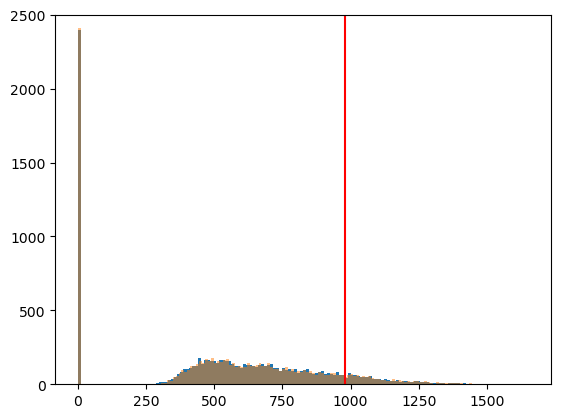

In [87]:
import matplotlib.pyplot as plt
plt.hist(pred,bins=150,alpha=1)
tp = pd.read_csv('./lgb_best.csv')['Income']
for i in test[(test['Age'] < 15)].index:
    tp[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    tp[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    tp[i] = 0
for i in range(len(pred)):
    if tp[i] < 200:
        tp[i] = 0
#     elif tp[i] > 0 and tp[i] < 200:
#         tp[i] = 200
plt.hist(tp,bins=150,alpha=0.5)
# plt.hist(train['Income'],bins=50)
plt.ylim(0,2500)
plt.vlines(np.mean([i for i in train['Income'] if i > 0]),0,3000,color='red')

In [88]:
train = pd.read_csv('./open/train.csv')
print(train[(train['Income'] > 0) & (train['Income'] < 3900)]['Income'].mean())
print(np.mean([i for i in pred if i > 0]))

947.7527819816612
705.7587440137931


In [89]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=0)
sub['Income'] = pred
sub.to_csv('./lgb.csv')

In [348]:
# 앙상블해봐바 -> 534.0415276786 #  lgbm feature 4, 0.55, 0.45

# target 인코딩해봐바 bad
# 학습 제약조건 아직 적용안해봄 -> not working 등
# stacking regressor

# 2024-04-03
# grb enssemble
# 제출복원준비